In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
import uncertainties
import os
from scipy.interpolate import interp1d
from dataclasses import dataclass
from typing import List, Tuple
from tqdm.notebook import tqdm
import pandas as pd
%matplotlib notebook

# Okamoto glass electron yield

We first simulate the measurement setup with different electron yields. Hereby we use the "nominal" position of the source, sample and PMT. Afterwards we will look at systematics.
The photon number $N$ produced by the sample increases linearly with the electron yield $y$, $N = y\cdot E_{deposited} + C$, where $C$ is the Cherenkov light contribution.

In [115]:
N_simulated = 1000000
yields = np.arange(0,1050,50)

In [68]:
for electron_yield in yields:
    os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 0  --yield_alphas 0 --yield_electrons {electron_yield} --output_file {electron_yield}_01um")

In [14]:
@dataclass
class Measurement:
    rate_sample : ufloat
    rate_background : ufloat
    temperature : float
    threshold: ufloat
    @property
    def rate(self):
        return self.rate_sample-self.rate_background

In [2]:
x,y = np.loadtxt("QE_PMT373.txt", unpack=1)
fQE = interp1d(x,y/100.,fill_value="extrapolate" )

PE_THRESHOLD = 0.2
MIN_DIFF_TIME = 20 
PLANCK = 4.1357e-15*1e9 # eV * ns
C = 299792458 #m/s


class Pulses:
    def __init__(self, initial_capacity=1000):
        self.probabilities = np.zeros(initial_capacity, dtype=np.float64)
        self.charges = np.zeros(initial_capacity, dtype=np.float64)
        self.size = 0
        
    def append(self, charge: float, probability: float) -> None:
        if self.size == len(self.charges):
            self._expand()
        self.charges[self.size] = charge
        self.probabilities[self.size] = min(probability, 1.0)
        self.size += 1
        
    def _expand(self):
        new_capacity = len(self.charges) * 2
        self.charges = np.resize(self.charges, new_capacity)
        self.probabilities = np.resize(self.probabilities, new_capacity)
        
    def count_detected(self, threshold: float) -> Tuple[float, int]:
        mask = self.charges[:self.size] >= threshold
        weights_over_threshold = self.probabilities[:self.size][mask]
        return np.sum(weights_over_threshold), np.sum(mask)

    def __len__(self):
        return self.size

@dataclass
class SimulationData:
    event_nr: np.ndarray
    hit_time: np.ndarray
    energy: np.ndarray
    charge: np.ndarray
    transit_time: np.ndarray
    relative_efficiency: np.ndarray
        
    def process_data(self, N) -> None:
        self.N_simulated = N
        self.pulses = Pulses()
        
        # Sort all data by event_nr and then by hit_time
        sort_indices = np.lexsort((self.hit_time, self.event_nr))
        self.event_nr = self.event_nr[sort_indices]
        self.hit_time = self.hit_time[sort_indices]
        self.energy = self.energy[sort_indices]
        self.charge = self.charge[sort_indices]
        self.transit_time = self.transit_time[sort_indices]
        self.relative_efficiency = self.relative_efficiency[sort_indices]
        
        self.detection_time = self.hit_time * 1e9 + self.transit_time
        wavelength = PLANCK * C / self.energy
        self.QE = fQE(wavelength)
        self.detection_probability = self.QE * self.relative_efficiency
        
        # Find the boundaries between events
        event_boundaries = np.where(np.diff(self.event_nr) != 0)[0] + 1
        event_boundaries = np.concatenate(([0], event_boundaries, [len(self.event_nr)]))
        
        for start, end in zip(event_boundaries[:-1], event_boundaries[1:]):
            self.check_SPE_MPE(self.detection_time[start:end], self.charge[start:end], self.detection_probability[start:end])

    
    def check_SPE_MPE(self, times: np.ndarray, charges: np.ndarray, DEs: np.ndarray) -> None:
        if len(times) == 1:
            self.pulses.append(charges[0], DEs[0])
            return
        
        time_diffs = np.diff(times)
        split_indices = np.where(time_diffs > MIN_DIFF_TIME)[0] + 1
        split_indices = np.concatenate(([0], split_indices, [len(times)]))
        
        cum_charges = np.add.reduceat(charges, split_indices[:-1])
        cum_des = np.add.reduceat(DEs, split_indices[:-1])
        
        for charge, de in zip(cum_charges, cum_des):
            self.pulses.append(charge, de)
        
    def hits_per_decay(self, pe_threshold: float = PE_THRESHOLD) -> ufloat:
        hits_detected, total_counts = self.pulses.count_detected(pe_threshold)
        rel_error = np.sqrt(total_counts) / total_counts if total_counts > 0 else 0
        detected_per_decay = hits_detected / self.N_simulated
        return ufloat(detected_per_decay, detected_per_decay * rel_error)
    

In [117]:
analysed_data = {}
for electron_yield in tqdm(yields):
    #analysed_data[electron_yield] = SimulationData(*np.loadtxt(f"{electron_yield}_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data[electron_yield] = SimulationData(*np.loadtxt(f"data_electron_yield/01um/{electron_yield}_01um_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data[electron_yield].process_data(N_simulated)

  0%|          | 0/21 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


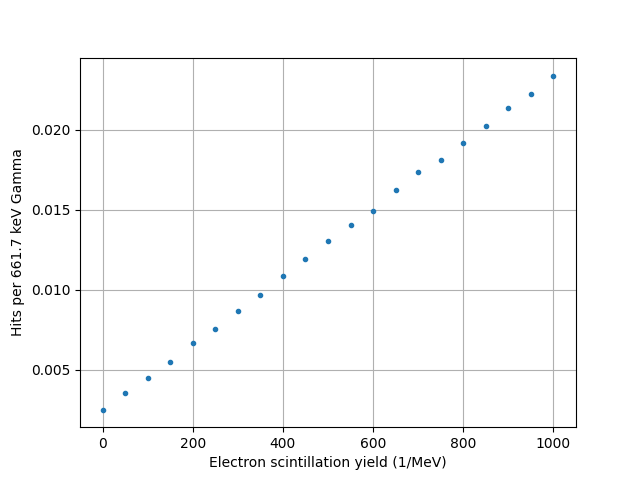

In [118]:
ufloat_values = [analysed_data[yield_val].hits_per_decay(0.3) for yield_val in yields]

yields = np.array(yields)
ufloat_values = np.array(ufloat_values)

plt.figure()
plt.errorbar(yields, [val.n for val in ufloat_values], yerr=[val.s for val in ufloat_values], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Hits per 661.7 keV Gamma')
plt.grid()
plt.show()


The Cs137 source was measured with Gamma spectroscopy and its activity was determined to be 631.8 kBq $\pm$ 11.8 kBq (sys).

<IPython.core.display.Javascript object>


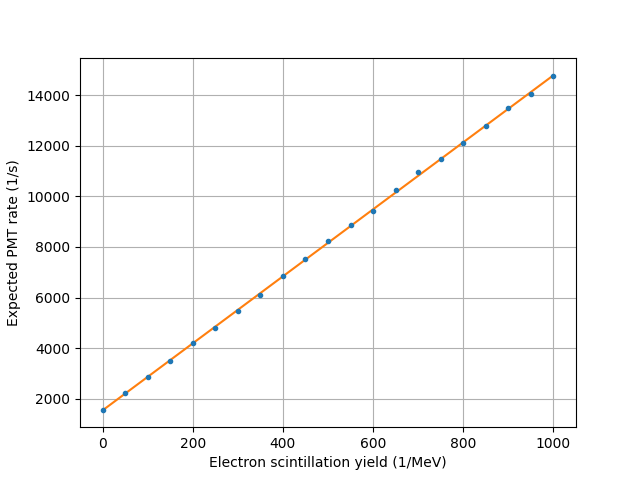

<IPython.core.display.Javascript object>


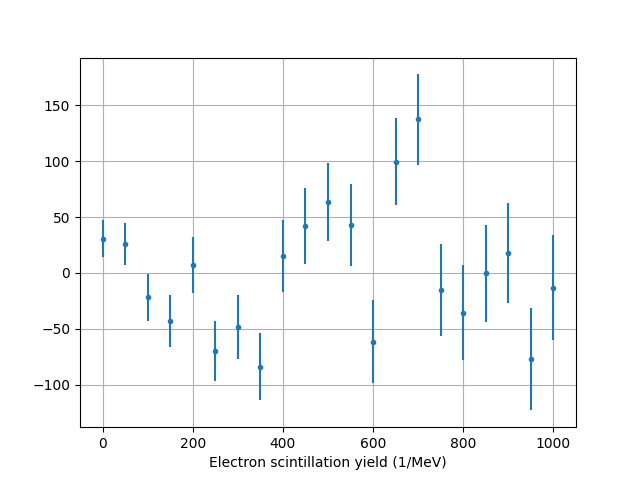

In [119]:
def lin(x,a,b):
    return x*a+b

CS137_activity = ufloat(631872, 11760)
pmt_rate = np.array(ufloat_values)*CS137_activity.n

popt,pcov = curve_fit(lin,yields, [val.n for val in pmt_rate], sigma=[val.s for val in pmt_rate], absolute_sigma=1 )
sim_slope, sim_const = uncertainties.correlated_values(popt, pcov)

plt.figure()
plt.errorbar(yields, [val.n for val in pmt_rate], yerr=[val.s for val in pmt_rate], fmt='.')
plt.plot(yields, lin(yields, *popt))
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Expected PMT rate (1/s)')
plt.grid()
plt.show()

plt.figure()
plt.errorbar(yields, np.array([val.n for val in pmt_rate])-lin(yields, *popt), yerr=[val.s for val in pmt_rate], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.grid()
plt.show()


In [10]:


    
measured_data = {}        
with open("analysed_data_Okamot_Cs137_with_sample_AF_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        measured_data[temperature] = Measurement(ufloat(rate, rate_err), ufloat(rate, rate_err), temperature, ufloat(0.3, 0.01))
with open("analysed_data_Okamot_Cs137_background_AF_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        measured_data[temperature].rate_background= ufloat(rate, rate_err)
        
print(measured_data)

{-50.0: Measurement(rate_sample=13976.595926508071+/-56.88709056621227, rate_background=7280.899660863023+/-8.536720547928988, temperature=-50.0, threshold=0.3+/-0.01), -40.0: Measurement(rate_sample=12701.66012394726+/-9.839563945953968, rate_background=6582.347322274894+/-12.464648864509243, temperature=-40.0, threshold=0.3+/-0.01), -30.0: Measurement(rate_sample=11586.45911308943+/-8.213513220602552, rate_background=5969.103817805766+/-7.962381416541651, temperature=-30.0, threshold=0.3+/-0.01), -25.0: Measurement(rate_sample=11085.169887643418+/-8.787610770089865, rate_background=5643.250815976784+/-10.637283034372665, temperature=-25.0, threshold=0.3+/-0.01), -20.0: Measurement(rate_sample=10596.967517102095+/-7.420854676135321, rate_background=5336.468083510155+/-12.668607840529997, temperature=-20.0, threshold=0.3+/-0.01), -15.0: Measurement(rate_sample=10129.171088171483+/-7.459934364166014, rate_background=5082.330517069289+/-9.155325504740262, temperature=-15.0, threshold=0.3

In [121]:
def get_yield(obj, rates):
    popt,pcov = curve_fit(lin,yields, [val.n for val in rates], sigma=[val.s for val in rates], absolute_sigma=1 )
    sim_slope, sim_const = uncertainties.correlated_values(popt, pcov)
    e_yield = (obj.rate-sim_const)/sim_slope
    return e_yield

def get_yield_with_systematics(obj: Measurement):
    baseline_rates = [CS137_activity.n*analysed_data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields]
    baseline_yield = get_yield(obj, baseline_rates)
    print(f"Yield: {baseline_yield}")
    #Sys uncertainty from threshold
    yield_sys = []
    for pe_threshold in np.random.normal(obj.threshold.n, obj.threshold.s, 1000):
        rates = [CS137_activity*analysed_data[yield_val].hits_per_decay(pe_threshold) for yield_val in yields]
        yield_sys.append(get_yield(obj, rates).n)
    sys_pe = np.std(yield_sys)
        
    #Sys uncertainty from source activity
    rates = [CS137_activity*analysed_data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields]
    sys_activity_yield = get_yield(obj, rates).s
    
    print(f"Systematic error from source activity {sys_activity_yield} and PE threshold {sys_pe} (1/MeV)")
    
    return baseline_yield, np.sqrt(sys_activity_yield**2+sys_pe**2)



In [122]:
for key, obj in measured_data.items():
    e_yields, u_sys = get_yield_with_systematics(obj)
    obj.calculated_yield = e_yields
    obj.yield_systematic_error = u_sys
    

Yield: 389+/-4
Systematic error from source activity 4.863879268102164 and PE threshold 0.8848717554548788 (1/MeV)
Yield: 345.7+/-1.3
Systematic error from source activity 2.2964005345283303 and PE threshold 0.7680032353962473 (1/MeV)
Yield: 307.8+/-1.0
Systematic error from source activity 1.9917814893377936 and PE threshold 0.6911673398666313 (1/MeV)
Yield: 294.6+/-1.1
Systematic error from source activity 2.031425291064751 and PE threshold 0.6578089436901917 (1/MeV)
Yield: 280.9+/-1.2
Systematic error from source activity 2.025050633885386 and PE threshold 0.6264418062359801 (1/MeV)
Yield: 264.7+/-1.0
Systematic error from source activity 1.8674178193023183 and PE threshold 0.5972025919730136 (1/MeV)
Yield: 250.8+/-1.1
Systematic error from source activity 1.8504810704172914 and PE threshold 0.5633322106050588 (1/MeV)
Yield: 238.3+/-1.0
Systematic error from source activity 1.800188572307308 and PE threshold 0.5553936689126766 (1/MeV)


<IPython.core.display.Javascript object>


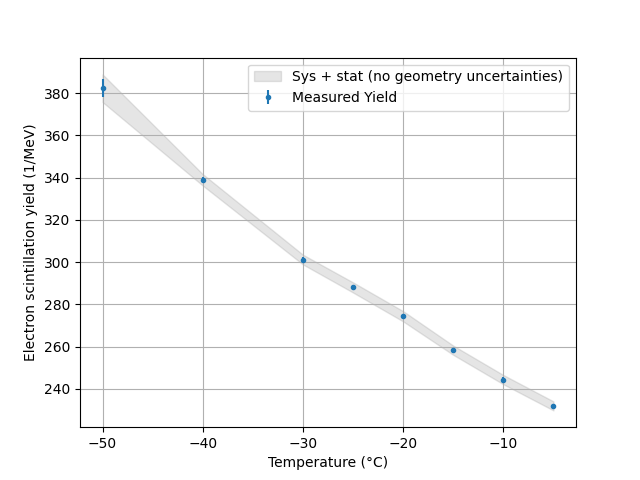

In [113]:
temperatures = np.array(list(measured_data.keys()))
yields = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields, yerr=yields_err, fmt='.', label='Measured Yield')
plt.fill_between(temperatures, yields - sys_err, yields + sys_err, color='gray', alpha=0.2, label='Sys + stat (no geometry uncertainties)')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Electron scintillation yield (1/MeV)')
plt.grid()
plt.legend()

# Show pl

To estimate the systematic uncertainty, we assume that the ratio of emitted Cherenkov $C$ to emitted scintillation light for a given electron yield $y$, $S(y) = y\cdot E_{deposited}$ is independent of position variations of the different components in the setup. This would mean that in a setup where we have less deposited energy (because for example the source if further away from the sample), the relative Cherenkov light intensity will reduce the same amount. This is obviously not true, but probably ok, as the setup geometry variations are small. Under this assumption, the total number of hits on PMT will be a $\epsilon \cdot (C+S)$, where $\epsilon$ is a geometry factor. 

Now, we simulate the setup varying all positions with their respective uncertainties at the average yield. Then we repeat this variation at yield = 0, to verify our assumption above.

In [42]:
average_yield = np.mean(yields)
N_simulated = 1000000
hits_per_decay = []
for n in tqdm(range(500)):
    os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 0  --yield_alphas 0 --yield_electrons {average_yield} --output_file tmp --systematics")
    tmp = SimulationData(*np.loadtxt(f"tmp_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    tmp.process_data(N_simulated)
    hits_per_decay.append(tmp.hits_per_decay())
    os.system("rm -rf tmp_*.dat")
    os.system("rm -rf tmp_*.json")

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
np.savetxt("systematics_average_yield.dat", ([val.n for val in hits_per_decay], [val.s for val in hits_per_decay]))

In [45]:
hitrate = [val.n for val in hits_per_decay]
hitratest = [val.s for val in hits_per_decay]
print(np.std(hitrate)*100/np.mean(hitrate), np.mean(hitratest)*100/np.mean(hitrate))

1.2694661581723736 0.5134306817231776


In [55]:
#Substract statistical uncertainty from systematics
rel_sys_stat = np.std(hitrate)/np.mean(hitrate)
rel_stat = np.mean(hitratest)/np.mean(hitrate)
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
print(f"Relative systematic uncertainty from geometry errors in setup: {round(systematic_relative*100,2)} %")

Relative systematic uncertainty from geometry errors in setup: 1.16 %


We repeat now with electron yield 0, to check if assumption above was okeish 

In [83]:

N_simulated = 1000000
hits_per_decay = []
for n in tqdm(range(250)):
    os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 0  --yield_alphas 0 --yield_electrons {0} --output_file tmp --systematics")
    tmp = SimulationData(*np.loadtxt(f"tmp_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    tmp.process_data(N_simulated)
    hits_per_decay.append(tmp.hits_per_decay())
    os.system("rm -rf tmp_*.dat")
    os.system("rm -rf tmp_*.json")

  0%|          | 0/250 [00:00<?, ?it/s]

In [87]:
np.savetxt("systematics_average_0yield.dat", ([val.n for val in hits_per_decay], [val.s for val in hits_per_decay]))

In [84]:
hitrate = [val.n for val in hits_per_decay]
hitratest = [val.s for val in hits_per_decay]
print(np.std(hitrate)*100/np.mean(hitrate), np.mean(hitratest)*100/np.mean(hitrate))

1.6596750387861363 1.0386468571007406


In [101]:
#Substract statistical uncertainty from systematics
rel_sys_stat = np.std(hitrate)/np.mean(hitrate)
rel_stat = np.mean(hitratest)/np.mean(hitrate)
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
print(f"Relative systematic uncertainty from geometry errors in setup (yield = 0): {round(systematic_relative*100,2)} %")

Relative systematic uncertainty from geometry errors in setup (yield = 0): 1.29 %


<IPython.core.display.Javascript object>


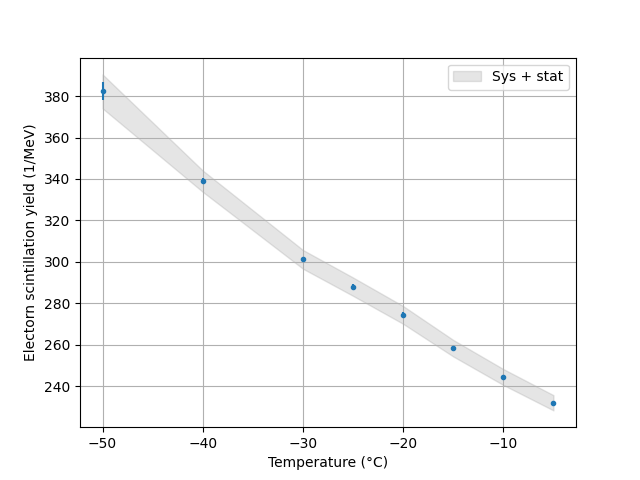

In [112]:
#Include geometry sys uncertainty 
temperatures = np.array(list(measured_data.keys()))
yields = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err + yields*yields*systematic_relative*systematic_relative)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields, yerr=yields_err, fmt='.')
plt.fill_between(temperatures, yields - sys_err, yields + sys_err, color='gray', alpha=0.2, label='Sys + stat')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Electorn scintillation yield (1/MeV)')
plt.grid()
plt.legend()


In [113]:
np.savetxt("okamoto_electron_yield_01mmStep.dat", np.array([temperatures, yields, yields_err, sys_err]).T,header=("Temperature \t electron_yield(1/Mev) \t yield_error_statistical \t yield_error_sys+statistical"))

## Alpha Yield

In [2]:
N_simulated = 1000000

In [ ]:
N_simulated = 100000
hits_per_decay = []
for n in tqdm(range(20)):
    air_yield = np.random.normal(18.7, 1.2)
    os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 1  --yield_alphas {air_yield} --yield_electrons 0 --output_file tmp --systematics")
    tmp = SimulationData(*np.loadtxt(f"tmp_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    tmp.process_data(N_simulated)
    hits_per_decay.append(tmp.hits_per_decay())
    os.system("rm -rf tmp_*.dat")
    os.system("rm -rf tmp_*.json")

In [90]:
hitrate = [val.n for val in hits_per_decay]
hitratest = [val.s for val in hits_per_decay]
print(np.mean(hitratest), np.std(hitrate)*100/np.mean(hitrate), np.mean(hitratest)*100/np.mean(hitrate))

0.00020338376025704418 34.35462823473323 1.3274908887505663


In [33]:
np.savetxt("systematics_air_yield_0.1mm.dat", ([val.n for val in hits_per_decay], [val.s for val in hits_per_decay]))

In [69]:
N_simulated = 100000
yields_a = np.append(np.arange(10,120,10), np.arange(51,60,1))
yields_e = np.arange(175,450,25)

In [68]:


# for yield_e in tqdm(yields_e):
#     yield_a = 0
#     os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 1  --yield_alphas {yield_a} --yield_electrons {yield_e} --output_file data_alpha_yield/01um/{yield_a}_{yield_e}")
    
    
for yield_a in tqdm(yields_a):
    yield_e = 0
    os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 1  --yield_alphas {yield_a} --yield_electrons {0} --output_file data_alpha_yield/01um/{yield_a}_{yield_e}")


  0%|          | 0/9 [00:00<?, ?it/s]

In [70]:
analysed_data_e = {}
for yield_e in tqdm(yields_e):
    yield_a = 0
    analysed_data_e[yield_e] = SimulationData(*np.loadtxt(f"data_alpha_yield/01um/{yield_a}_{yield_e}_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data_e[yield_e].process_data(N_simulated)

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


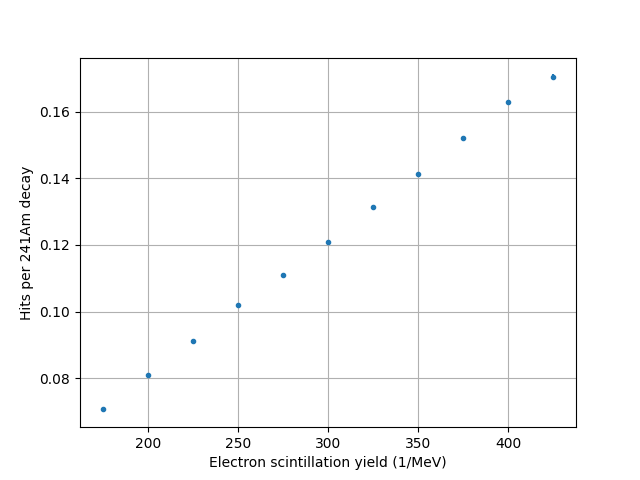

In [71]:
ufloat_values = [analysed_data_e[yield_val].hits_per_decay(0.25) for yield_val in yields_e]

yields = np.array(yields_e)
ufloat_values = np.array(ufloat_values)

plt.figure()
plt.errorbar(yields, [val.n for val in ufloat_values], yerr=[val.s for val in ufloat_values], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Hits per 241Am decay')
plt.grid()
plt.show()


<IPython.core.display.Javascript object>


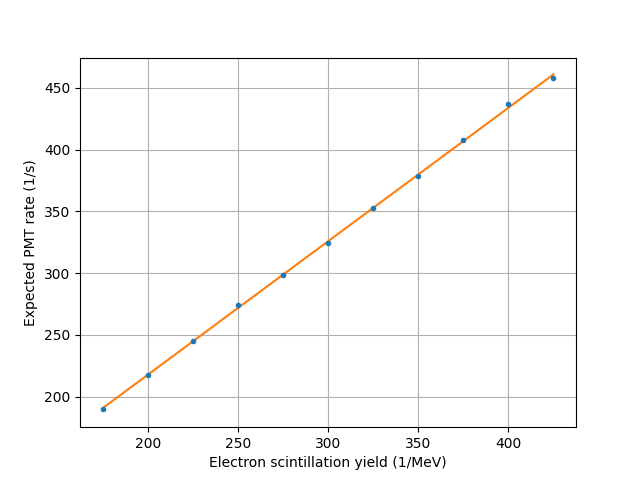

<IPython.core.display.Javascript object>


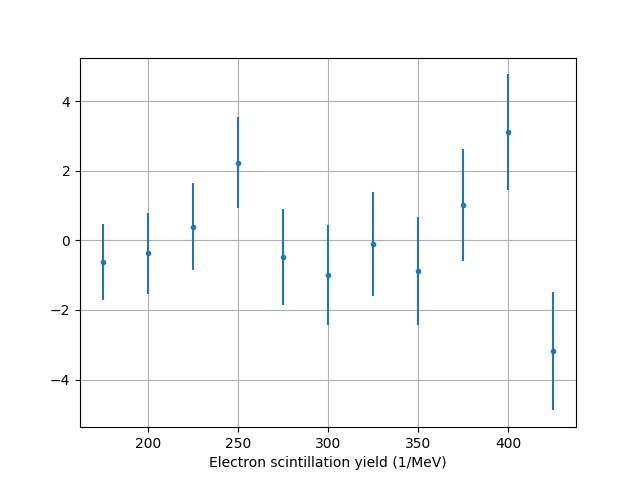

In [72]:
def lin(x,a,b):
    return x*a+b

AM241_activity = ufloat(2684, 82) 
pmt_rate = np.array(ufloat_values)*AM241_activity.n

popt,pcov = curve_fit(lin,yields, [val.n for val in pmt_rate], sigma=[val.s for val in pmt_rate], absolute_sigma=1 )
sim_slope_e, sim_const_e = uncertainties.correlated_values(popt, pcov)

plt.figure()
plt.errorbar(yields, [val.n for val in pmt_rate], yerr=[val.s for val in pmt_rate], fmt='.')
plt.plot(yields, lin(yields, *popt))
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Expected PMT rate (1/s)')
plt.grid()
plt.show()

plt.figure()
plt.errorbar(yields, np.array([val.n for val in pmt_rate])-lin(yields, *popt), yerr=[val.s for val in pmt_rate], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.grid()
plt.show()


In [73]:
analysed_data_a = {}
yields_a = np.arange(10,110,10)
for yield_a in tqdm(yields_a):
    yield_e = 0
    analysed_data_a[yield_a] = SimulationData(*np.loadtxt(f"data_alpha_yield/01um/{yield_a}_{yield_e}_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data_a[yield_a].process_data(N_simulated)
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [87]:
a = SimulationData(*np.loadtxt(f"data_alpha_yield/01mm/{100}_{0}_01mm_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
a.process_data(N_simulated)
a.hits_per_decay(0.25)

5.053929078325395+/-0.003466181438398803

In [85]:
analysed_data_a[100].hits_per_decay(0.25)

0.46166604150045615+/-0.0010467030141982196

<IPython.core.display.Javascript object>


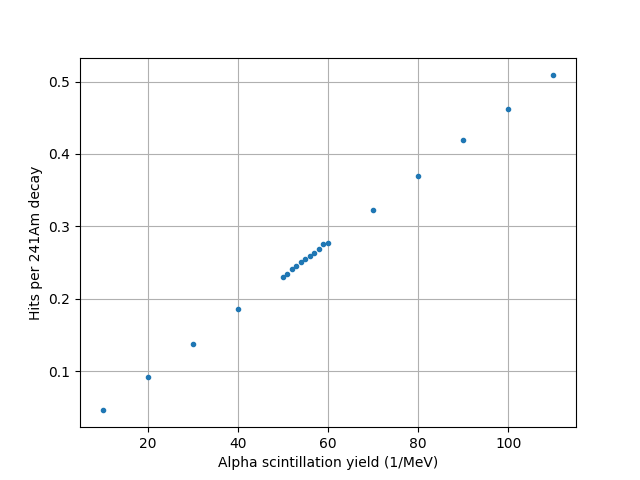

In [82]:
yields = np.array(yields_a)
ufloat_values = [analysed_data_a[yield_val].hits_per_decay(0.25) for yield_val in yields]

ufloat_values = np.array(ufloat_values)

plt.figure()
plt.errorbar(yields, [val.n for val in ufloat_values], yerr=[val.s for val in ufloat_values], fmt='.')
plt.xlabel('Alpha scintillation yield (1/MeV)')
plt.ylabel('Hits per 241Am decay')
plt.grid()
plt.show()


<IPython.core.display.Javascript object>


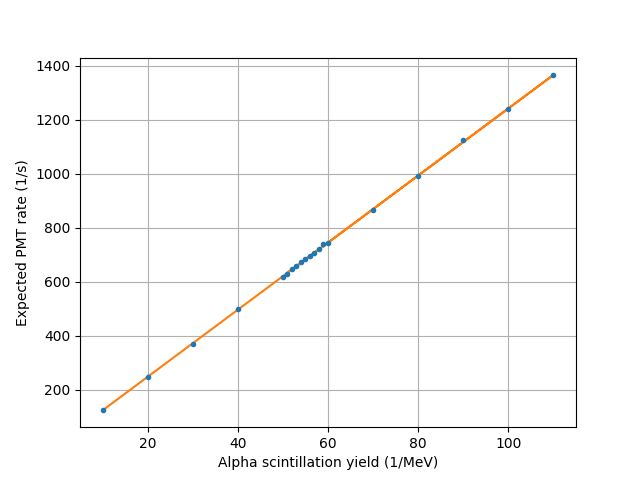

<IPython.core.display.Javascript object>


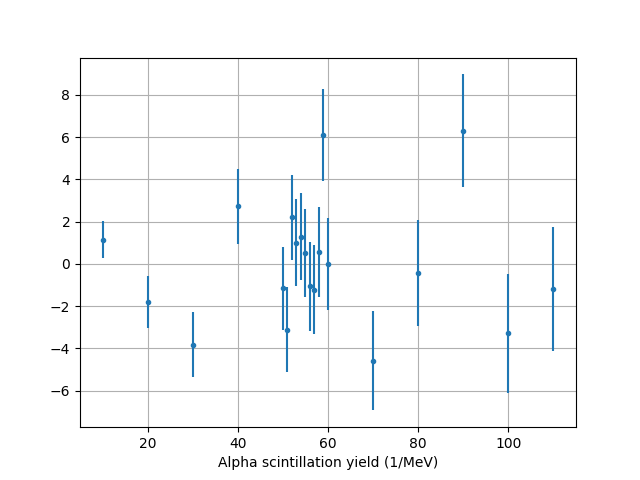

In [83]:
def lin(x,a,b):
    return x*a+b

AM241_activity = ufloat(2684, 82) 
pmt_rate = np.array(ufloat_values)*AM241_activity.n

popt,pcov = curve_fit(lin,yields, [val.n for val in pmt_rate], sigma=[val.s for val in pmt_rate], absolute_sigma=1 )
sim_slope_a, sim_const_a = uncertainties.correlated_values(popt, pcov)

plt.figure()
plt.errorbar(yields, [val.n for val in pmt_rate], yerr=[val.s for val in pmt_rate], fmt='.')
plt.plot(yields, lin(yields, *popt))
plt.xlabel('Alpha scintillation yield (1/MeV)')
plt.ylabel('Expected PMT rate (1/s)')
plt.grid()
plt.show()

plt.figure()
plt.errorbar(yields, np.array([val.n for val in pmt_rate])-lin(yields, *popt), yerr=[val.s for val in pmt_rate], fmt='.')
plt.xlabel('Alpha scintillation yield (1/MeV)')
plt.grid()
plt.show()


In [76]:
def get_electron_yield_at_temperature(temperature, fname = "okamoto_electron_yield_01mmStep.dat"):
    temperatures, yields, yields_err, sys_err = np.loadtxt(fname, unpack=1)
    return interp1d(temperatures, yields)(temperature), interp1d(temperatures, sys_err)(temperature)

In [77]:
def get_yield(obj, rates):
    popt,pcov = curve_fit(lin,yields, [val.n for val in rates], sigma=[val.s for val in rates], absolute_sigma=0 )
    sim_slope, sim_const = uncertainties.correlated_values(popt, pcov)
    e_yield = (obj.rate-sim_const)/sim_slope
    #print(sim_const)
    return e_yield

def get_yield_with_systematics(obj: Measurement, data):
    electron_yield, sys_electron_yield = get_electron_yield_at_temperature(obj.temperature)
    rate_from_electrons = sim_slope_e*electron_yield+sim_const_e
    baseline_rates = [rate_from_electrons+AM241_activity.n*data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields_a]
    baseline_yield = get_yield(obj, baseline_rates)
    
    print(f"Yield: {baseline_yield}, rate electrons {rate_from_electrons}")
    #Sys uncertainty from threshold and electron yield systematics
    yield_sys = []
    for pe_threshold in np.random.normal(obj.threshold.n, obj.threshold.s, 100):
        #sampled_e_yield = np.random.normal(electron_yield, sys_electron_yield, 1)[0]
        #rate_from_electrons = sim_slope_e*electron_yield+sim_const_e
        rates = [rate_from_electrons+AM241_activity*data[yield_val].hits_per_decay(pe_threshold) for yield_val in yields_a]
        yield_sys.append(get_yield(obj, rates).n)
        
    sys_pe = np.std(yield_sys)
        
    #Sys uncertainty from source activity
    rates = [AM241_activity*data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields_a]
    sys_activity_yield = get_yield(obj, rates).s
    
    print(f"Systematic error from source activity {sys_activity_yield} and PE threshold {sys_pe} (1/MeV)")
    
    return baseline_yield, np.sqrt(sys_activity_yield**2+sys_pe**2)



In [78]:
measured_data = {}        
with open("analysed_data_025PEcut_Okamot_Am241_with_sample_nearer_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        measured_data[temperature] = Measurement(ufloat(rate, rate_err), ufloat(rate, rate_err), temperature, ufloat(0.25, 0.01))
with open("analysed_data_025PEcut_Okamot_Am241_background_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        if temperature in measured_data:
            measured_data[temperature].rate_background= ufloat(rate, rate_err)
        
print(measured_data)

{-50.0: Measurement(rate_sample=1291.2897520392578+/-2.3844196021503294, rate_background=71.59211960726017+/-12.495719850044274, temperature=-50.0, threshold=0.25+/-0.01), -40.0: Measurement(rate_sample=1216.3016581604966+/-2.723660585157294, rate_background=59.117553547172555+/-10.227305826921464, temperature=-40.0, threshold=0.25+/-0.01), -30.0: Measurement(rate_sample=1123.6162576498066+/-4.081455605046697, rate_background=55.99986671329307+/-6.463721356660603, temperature=-30.0, threshold=0.25+/-0.01), -25.0: Measurement(rate_sample=1069.6498509444336+/-3.4388986434537765, rate_background=49.00311609036533+/-11.07169299090185, temperature=-25.0, threshold=0.25+/-0.01), -20.0: Measurement(rate_sample=1036.0302427889335+/-2.560811442007705, rate_background=47.827052709214364+/-8.181224953496228, temperature=-20.0, threshold=0.25+/-0.01), -15.0: Measurement(rate_sample=1001.0183308346164+/-2.1781742447669825, rate_background=42.86285480172447+/-7.463091732618944, temperature=-15.0, th

In [79]:
for key, obj in measured_data.items():
    e_yields, u_sys = get_yield_with_systematics(obj, analysed_data_a)
    obj.calculated_yield = e_yields
    obj.yield_systematic_error = u_sys
    

Yield: 64.8+/-1.0, rate electrons 414.6+/-0.7
Systematic error from source activity 1.0322857391739633 and PE threshold 0.08961115976191464 (1/MeV)
Yield: 63.6+/-0.9, rate electrons 367.8+/-0.5
Systematic error from source activity 0.8606852964855837 and PE threshold 0.10472709850956259 (1/MeV)
Yield: 59.7+/-0.6, rate electrons 327.0+/-0.4
Systematic error from source activity 0.6252175301374613 and PE threshold 0.0848746246070782 (1/MeV)
Yield: 57.0+/-0.9, rate electrons 312.7+/-0.4
Systematic error from source activity 0.9390275222050061 and PE threshold 0.0713249111451014 (1/MeV)
Yield: 55.6+/-0.7, rate electrons 298.0+/-0.4
Systematic error from source activity 0.6973022978315401 and PE threshold 0.073696272387701 (1/MeV)
Yield: 54.6+/-0.6, rate electrons 280.6+/-0.4
Systematic error from source activity 0.6331909272073625 and PE threshold 0.07184586651914024 (1/MeV)
Yield: 53.0+/-0.6, rate electrons 265.6+/-0.5
Systematic error from source activity 0.5614427478993518 and PE thresh

<IPython.core.display.Javascript object>


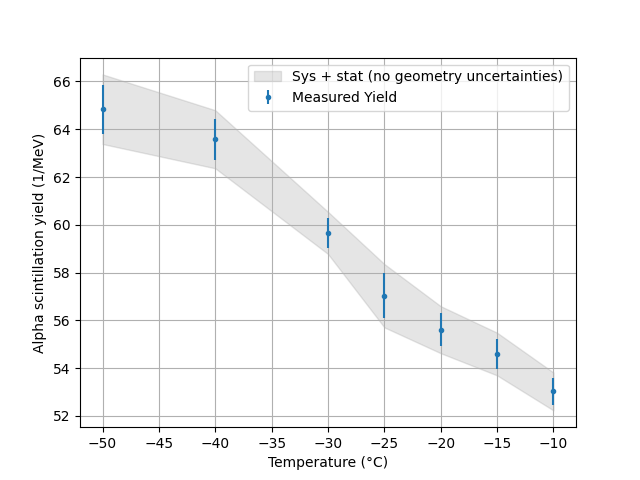

In [81]:
temperatures = np.array(list(measured_data.keys()))
yields_ = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields_, yerr=yields_err, fmt='.', label='Measured Yield')
plt.fill_between(temperatures, yields_ - sys_err, yields_ + sys_err, color='gray', alpha=0.2, label='Sys + stat (no geometry uncertainties)')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Alpha scintillation yield (1/MeV)')
plt.grid()
plt.legend()

# Show pl

In [94]:
#average_yield = 60#np.mean(yields)
#average_yield_e = 300 #does not really matter in this case
#N_simulated = 50000
#hits_per_decay = []
for n in tqdm(range(200)):
    os.system(f"./OMSim_scintillation_yield -n {N_simulated} --detector_type 1  --yield_alphas {average_yield} --yield_electrons {average_yield_e} --output_file tmp --systematics")
    tmp = SimulationData(*np.loadtxt(f"tmp_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    tmp.process_data(N_simulated)
    hits_per_decay.append(tmp.hits_per_decay())
    os.system("rm -rf tmp_*.dat")
    os.system("rm -rf tmp_*.json")

  0%|          | 0/200 [00:00<?, ?it/s]

In [99]:
np.savetxt("alpha_systematics_average_yield_01um.dat", ([val.n for val in hits_per_decay], [val.s for val in hits_per_decay]))

<IPython.core.display.Javascript object>


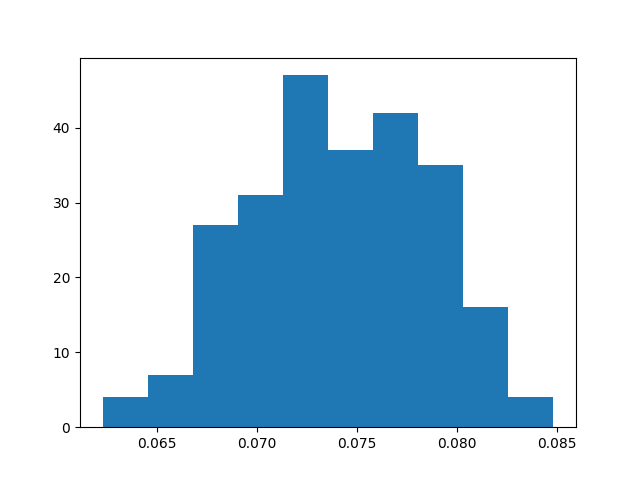

(array([ 4.,  7., 27., 31., 47., 37., 42., 35., 16.,  4.]),
 array([0.06228463, 0.06453928, 0.06679393, 0.06904859, 0.07130324,
        0.07355789, 0.07581255, 0.0780672 , 0.08032185, 0.0825765 ,
        0.08483116]),
 <BarContainer object of 10 artists>)

In [97]:
plt.figure()
plt.hist(hitrate)

In [100]:
hitrate = [val.n for val in hits_per_decay]
hitratest = [val.s for val in hits_per_decay]
print(np.std(hitrate)*100/np.mean(hitrate), np.mean(hitratest)*100/np.mean(hitrate))

6.020066559634513 0.9833958384335469


In [101]:
#Substract statistical uncertainty from systematics
rel_sys_stat = np.std(hitrate)/np.mean(hitrate)
rel_stat = np.mean(hitratest)/np.mean(hitrate)
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
print(f"Relative systematic uncertainty from geometry errors in setup: {round(systematic_relative*100,3)} %")

Relative systematic uncertainty from geometry errors in setup: 5.939 %


<IPython.core.display.Javascript object>


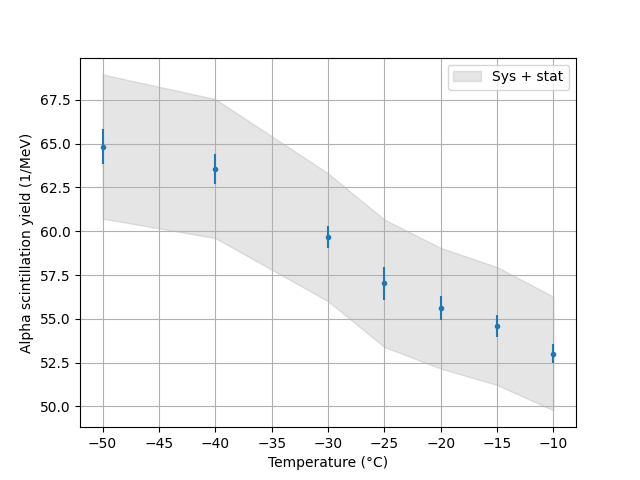

In [103]:
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
#Include geometry sys uncertainty 
temperatures = np.array(list(measured_data.keys()))
yields = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err + yields*yields*systematic_relative*systematic_relative)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields, yerr=yields_err, fmt='.')
plt.fill_between(temperatures, yields - sys_err, yields + sys_err, color='gray', alpha=0.2, label='Sys + stat')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Alpha scintillation yield (1/MeV)')
plt.grid()
plt.legend()


In [104]:
np.savetxt("okamoto_alpha_yield_01umStep.dat", np.array([temperatures, yields, yields_err, sys_err]).T,header=("Temperature \t alpha_yield(1/Mev) \t yield_error_statistical \t yield_error_sys+statistical"))